In [1]:
%run /data/NNDSP/anal/analysis_notebooks/util.ipynb

/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


# Baracus Performance

## Setup

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import subprocess
from datetime import date
import re

In [3]:
analysis_version = "2017_07_07"
project_dir_absolute = Path('/gpfs/gsfs6/users/NNDSP')

# Project Directory
project_dir = Path(project_dir_absolute) # needs to be pathlib.Path object

# Bids Directory
bids_bar = project_dir.joinpath('derived/bar_subj') # baracus bids

# Brain Age File
brain_age_file = project_dir.joinpath('anal/analysis_notebooks/NNDSP_famid.csv')

print(brain_age_file.absolute())

/gpfs/gsfs6/users/NNDSP/anal/analysis_notebooks/NNDSP_famid.csv


## Load Baracus Data

In [4]:
bar_subj = [p.as_posix() for p in bids_bar.glob('sub-*')] # search all subj in baracus directory
df_bar_subj = pd.DataFrame(bar_subj) # turn the subjects into df
df_bar_subj.columns = ['subj_path'] # rename column of subj paths to subj_path
df_bar_subj = df_bar_subj.assign(participant = lambda df: df.subj_path.str.extract('sub-(\d{2,4})', expand=True)) # add participant number column

In [5]:
df_single_subject = get_single_subject(df_bar_subj, to_int=False) # get cortical thickness, cortical surface area, sub cort volume and stacked anat age predictions

In [6]:
# Getting Age
df_target = pd.read_csv(brain_age_file, sep=',') # open file with ages
del df_target['nuclear_fam_id']
del df_target['Sex']
del df_target['MRN']

In [7]:
df_bar_subj = df_bar_subj.merge(df_single_subject, on='participant') # merge subje with their age predictions

In [8]:
df_bar_subj = df_bar_subj.assign(MASKID = lambda df: pd.DataFrame([int(x) for x in df.participant]))
df_bar_subj = df_bar_subj.merge(df_target, on='MASKID') # merge age predictions with actual age 

## Mean Absolute Error

In [9]:
# error of baracus model
from sklearn.metrics import mean_absolute_error

# calculate absolute error for each modality
print("Mean Absolute Error (Aseg):", mean_absolute_error(df_bar_subj.iloc[:, 2], df_bar_subj.iloc[:, 7]))
print("Mean Absolute Error (Area):", mean_absolute_error(df_bar_subj.iloc[:, 3], df_bar_subj.iloc[:, 7]))
print("Mean Absolute Error (Thickness):", mean_absolute_error(df_bar_subj.iloc[:, 4], df_bar_subj.iloc[:, 7]))
print("Mean Absolute Error (Stacked Model):", mean_absolute_error(df_bar_subj.iloc[:, 5], df_bar_subj.iloc[:, 7]))

Mean Absolute Error (Aseg): 10.7794454526
Mean Absolute Error (Area): 105.017535768
Mean Absolute Error (Thickness): 15.864500892
Mean Absolute Error (Stacked Model): 13.7877541396


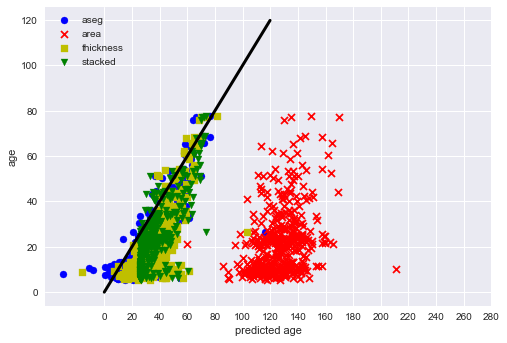

In [10]:
bar_plot(df_bar_subj)

# Train LeiCA_LIFE Models on NNDSP Data

In [11]:
# Getting Brain Age
df_target = pd.read_csv(brain_age_file, sep=',')
del df_target['nuclear_fam_id']
del df_target['MRN']

## Setup

In [12]:
from pathlib import Path
import pandas as pd
import numpy as np
import subprocess
from datetime import date
import re

In [13]:
analysis_version = "2017_07_07"
project_dir_absolute = Path('/gpfs/gsfs6/users/NNDSP')

# Project Directory
project_dir = Path(project_dir_absolute) # needs to be pathlib.Path object

# Bids Directory
bids_fs = project_dir.joinpath('derived/fs5.3_subj') # freesurfer bids
bids_bar = project_dir.joinpath('derived/bar_subj') # baracus bids

# Brain Age File
brain_age_file = project_dir.joinpath('anal/analysis_notebooks/NNDSP_famid.csv')

print(brain_age_file.absolute())

/gpfs/gsfs6/users/NNDSP/anal/analysis_notebooks/NNDSP_famid.csv


## Load Subjects

In [14]:
import os
from glob import glob

# get the subjects in the freesurfer directory
subj_dirs = [os.path.basename(s) for s in sorted(glob(os.path.join(bids_fs, "sub-*")))]

## Extract Freesurfer Data

In [15]:
subjects_to_analyze = subject_to_anal(subj_dirs, bids_bar)
features = extract_features(subjects_to_analyze, bids_bar)

## Train Freesurfer Data

### Single Modal: Cortical Thickness

In [16]:
df_data_ct = get_source_data('thickness', features, df_target) # extract thickness info from features
df_data_ct = df_data_ct.sort_values(by='MASKID')

In [17]:
#split test and train data into equal parts
X_train_ct, X_test_ct, y_train_ct, y_test_ct, pipe_ct = train_test_pipeline(df_data_ct.iloc[:, :5124], df_data_ct.iloc[:,5126], test_size = 0.5, random_state=None)
# fit model
pipe_ct.fit(X=X_train_ct, y=y_train_ct)

Pipeline(steps=[('fill_missing', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('var_thr', VarianceThreshold(threshold=0.0)), ('normalize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regression_model', SVR(C=1.0, cache_size=1000, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])

In [18]:
# prediction and errors
y_predicted_train_ct = pipe_ct.predict(X_train_ct)
y_predicted_test_ct = pipe_ct.predict(X_test_ct)

In [19]:
# test mean absolute error
from sklearn.metrics import mean_absolute_error, r2_score

print("Mean Absolute Error (Train):", mean_absolute_error(y_train_ct, y_predicted_train_ct))
print("Mean Absolute Error (Test):", mean_absolute_error(y_test_ct, y_predicted_test_ct))

Mean Absolute Error (Train): 0.0992481112286
Mean Absolute Error (Test): 5.87543515971


In [20]:
from sklearn.cross_validation import cross_val_predict
# cross validation prediction 
y_predicted_ct_cv = cross_val_predict(pipe_ct, X_train_ct, y_train_ct)

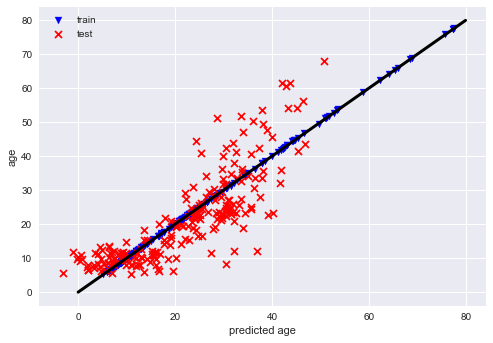

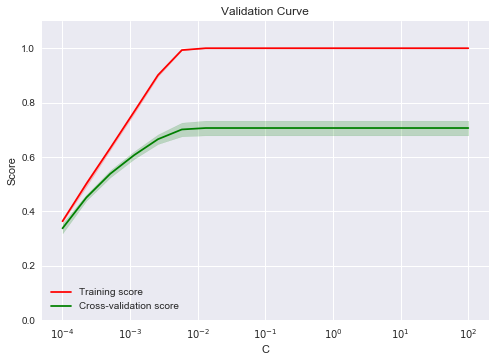

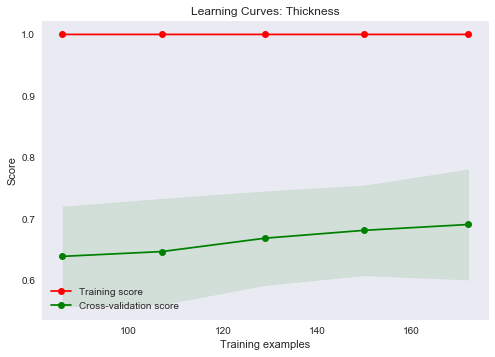

In [21]:
plot_pred(y_predicted_train_ct, y_train_ct, y_predicted_test_ct, y_test_ct) # plot predicted versus age
plot_validation_curve(pipe_ct, X_train_ct, y_train_ct) # plot C versus training and validation score
learning_curve_fct(X_train_ct, y_train_ct, 'Thickness', pipe_ct) # plot number of features training examples versus validation close

### Single Modal: Subcortical Volumes

In [22]:
df_data_sv = get_source_data('aseg', features, df_target)
df_data_sv = df_data_sv.sort_values(by='MASKID')

In [23]:
# Train Test Split
X_train_sv, X_test_sv, y_train_sv, y_test_sv, pipe_sv = train_test_pipeline(df_data_sv.iloc[:, :66], df_data_sv.iloc[:,68], test_size = 0.5, random_state=666, model='yes', model_train=X_train_ct, model_test=X_test_ct)

# fit model
pipe_sv.fit(X=X_train_sv, y= y_train_sv.as_matrix().ravel())

Pipeline(steps=[('fill_missing', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('var_thr', VarianceThreshold(threshold=0.0)), ('normalize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regression_model', SVR(C=1.0, cache_size=1000, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])

In [24]:
# prediction and errors
y_predicted_train_sv = pipe_sv.predict(X_train_sv)
y_predicted_test_sv = pipe_sv.predict(X_test_sv)

In [25]:
# test mean absolute error
from sklearn.metrics import mean_absolute_error, r2_score

print("Mean Absolute Error (Train):", mean_absolute_error(y_train_sv, y_predicted_train_sv))
print("Mean Absolute Error (Test):", mean_absolute_error(y_test_sv, y_predicted_test_sv))

Mean Absolute Error (Train): 4.06572456166
Mean Absolute Error (Test): 5.12474647521


In [26]:
from sklearn.cross_validation import cross_val_predict
# cross validation prediction
y_predicted_sv_cv = cross_val_predict(pipe_sv, X_train_sv, y_train_sv.as_matrix().ravel())

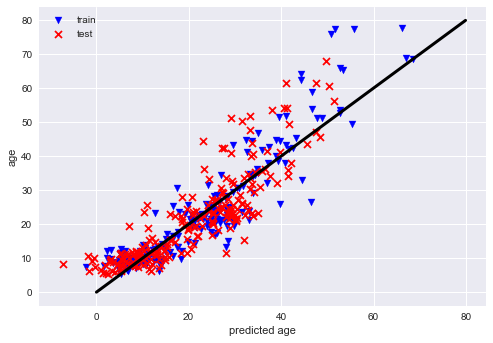

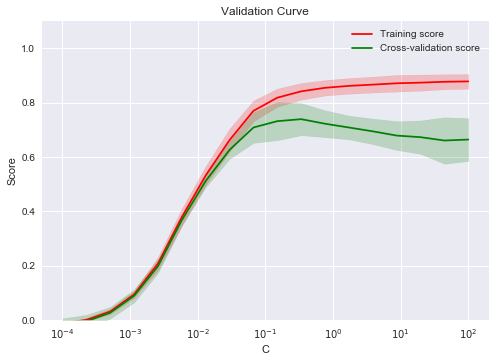

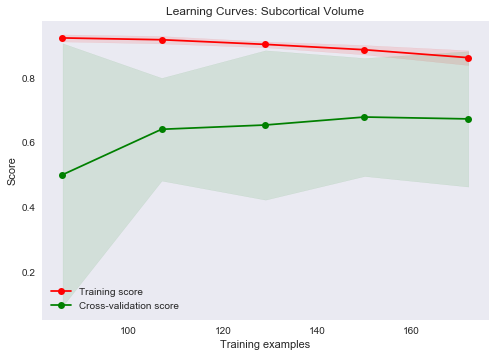

In [27]:
plot_pred(y_predicted_train_sv, y_train_sv, y_predicted_test_sv, y_test_sv) # plot predicted age vs age
plot_validation_curve(pipe_sv, X_train_sv, y_train_sv.as_matrix().ravel()) # plot C versis training and validation scroe
learning_curve_fct(X_train_sv, y_train_sv.as_matrix().ravel(), 'Subcortical Volume', pipe_sv) # plot number of training examples vs training and validation score

In [28]:
%store X_train_sv 
%store X_test_sv
%store y_train_sv 
%store y_test_sv

Stored 'X_train_sv' (DataFrame)
Stored 'X_test_sv' (DataFrame)
Stored 'y_train_sv' (DataFrame)
Stored 'y_test_sv' (DataFrame)


### Single Modal: Cortical Surface Area

In [29]:
df_data_ca = get_source_data('area', features, df_target)
df_data_ca = df_data_ca.sort_values(by='MASKID')

In [30]:
# Train Test Split

#split test and train data into equal parts
X_train_ca, X_test_ca, y_train_ca, y_test_ca, pipe_ca = train_test_pipeline(df_data_ca.iloc[:, :5124], df_data_ca.iloc[:,5126], test_size = 0.5, random_state=666, model='yes', model_train=X_train_ct, model_test=X_test_ct)

# fit model
pipe_ca.fit(X=X_train_ca, y=y_train_ca.as_matrix().ravel())

Pipeline(steps=[('fill_missing', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('var_thr', VarianceThreshold(threshold=0.0)), ('normalize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regression_model', SVR(C=1.0, cache_size=1000, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])

In [31]:
# prediction and errors
y_predicted_train_ca = pipe_ca.predict(X_train_ca)
y_predicted_test_ca = pipe_ca.predict(X_test_ca)

In [32]:
# test mean absolute error
from sklearn.metrics import mean_absolute_error, r2_score

print("Mean Absolute Error (Train):", mean_absolute_error(y_train_ca, y_predicted_train_ca))
print("Mean Absolute Error (Test):", mean_absolute_error(y_test_ca, y_predicted_test_ca))

Mean Absolute Error (Train): 0.0994072504544
Mean Absolute Error (Test): 7.56691852656


In [33]:
from sklearn.cross_validation import cross_val_predict
# cross validation prediction
y_predicted_ca_cv = cross_val_predict(pipe_ca, X_train_ca, y_train_ca.as_matrix().ravel())
print("Mean Absolute Error (Train):", mean_absolute_error(y_train_ca, y_predicted_ca_cv))

Mean Absolute Error (Train): 7.26133363047


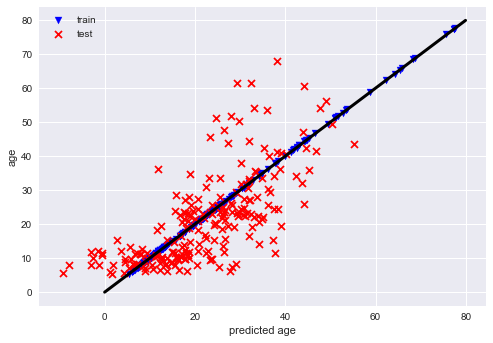

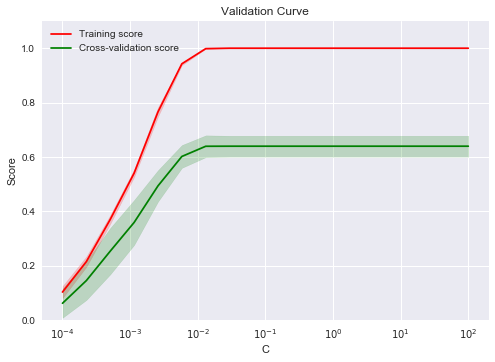

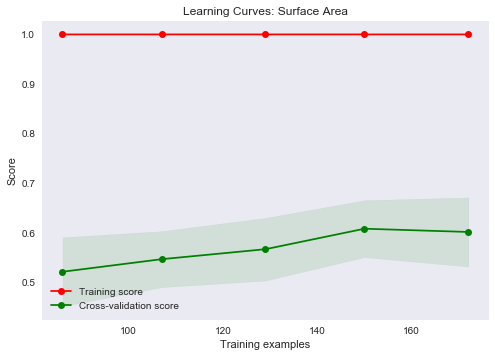

In [34]:
plot_pred(y_predicted_train_ca, y_train_ca, y_predicted_test_ca, y_test_ca)
plot_validation_curve(pipe_ca, X_train_ca, y_train_ca.as_matrix().ravel())
learning_curve_fct(X_train_ca, y_train_ca.as_matrix().ravel(), 'Surface Area', pipe_ca)

In [35]:
%store df_data_ct
%store df_data_sv
%store df_data_ca

Stored 'df_data_ct' (DataFrame)
Stored 'df_data_sv' (DataFrame)
Stored 'df_data_ca' (DataFrame)


### Stacked Anatomy

In [36]:
# stack predicted values
# get stacked age predictions (test and train) for ct
df_y_ct = get_stacked_ages(y_train_ct, y_predicted_train_ct, y_predicted_ct_cv, y_test_ct, y_predicted_test_ct, first=True)
# get stacked age prediction (test and train) for ca
df_y_ca = get_stacked_ages(y_train_ca, y_predicted_train_ca, y_predicted_ca_cv, y_test_ca, y_predicted_test_ca)
# get stacked age prediction (test and train) for sv
df_y_sv = get_stacked_ages(y_train_sv, y_predicted_train_sv, y_predicted_sv_cv, y_test_sv, y_predicted_test_sv)

In [37]:
# stacking function inputes
target = 'age'

source_dict = {'aseg': df_y_sv, 'ct': df_y_ct,'ca': df_y_ca}

source_selection_dict = {'fs': ['aseg', 'ct', 'ca'],}

#### Training Random Forest Function

In [38]:
scores_test, dd_train, dd_test, pipe_stack = stacking(source_dict, source_selection_dict, target, show=False)

Fitting stacking model
best max_depth: 4


In [39]:
from sklearn.metrics import mean_absolute_error

print("Mean Absolute Error (Train):", mean_absolute_error(dd_train.age_at_scan, dd_train.pred_age_train))
print("Mean Absolute Error (Test):", mean_absolute_error(dd_test.age_at_scan, dd_test.pred_age_test))
scores_test

Mean Absolute Error (Train): 2.84247159903
Mean Absolute Error (Test): 4.22323648588


,r2,rpear,rpear2,mae,medae
aseg,0.731067,0.860882,0.741117,5.124746,3.911817
ct,0.665421,0.821075,0.674165,5.875435,4.766449
ca,0.432129,0.693466,0.480895,7.566919,6.012662
mean_pred,0.758361,0.871697,0.759856,4.669013,3.744383
pred_age_test,0.759583,0.874338,0.764467,4.223236,2.439916


In [40]:
y_predicted_stack_cv = cross_val_predict(pipe_stack, dd_train.iloc[:,:3], dd_train.age_at_scan.values)
print("Mean Absolute Error (Train):", mean_absolute_error(dd_train.age_at_scan.values, y_predicted_stack_cv))

Mean Absolute Error (Train): 4.70408437841


# Train Basic Anatomical Features

## Setup

In [41]:
from pathlib import Path
import pandas as pd
import numpy as np
import subprocess
from datetime import date
import re

In [42]:
analysis_version = "2017_07_07"
project_dir_absolute = Path('/gpfs/gsfs6/users/NNDSP')

# Project Directory
project_dir = Path(project_dir_absolute) # needs to be pathlib.Path object

# Bids Directory
bids_bar = project_dir.joinpath('derived/bar_subj') # baracus bids

# Brain Age File
brain_age_file = project_dir.joinpath('anal/analysis_notebooks/NNDSP_famid.csv')

print(brain_age_file.absolute())

/gpfs/gsfs6/users/NNDSP/anal/analysis_notebooks/NNDSP_famid.csv


## Load Subjects

In [43]:
import os
from glob import glob

# get the subjects in the freesurfer directory
subj_dirs = [os.path.basename(s) for s in sorted(glob(os.path.join(bids_fs, "sub-*")))]

In [44]:
subjects_to_analyze = subject_to_anal(subj_dirs, bids_bar)

## Extract Anatomical Feature Data

In [45]:
df_atf = pd.DataFrame([])
df_atf = df_atf.assign(MASKID = [int(x[4:]) for x in subjects_to_analyze])
df_atf = df_atf.merge(df_target, on = 'MASKID')

In [46]:
white_matter, grey_matter, csf, intra_cran_vol = get_anat_features(subjects_to_analyze, bids_bar)

In [47]:
# calculate white matter fraction
white_matter = calc_fraction(white_matter, intra_cran_vol)
# calculate grey matter fraction
grey_matter = calc_fraction(grey_matter, intra_cran_vol)
# calculate csf fraction
csf = calc_fraction(csf, intra_cran_vol)

In [48]:
df_atf = df_atf.assign(Intra_Cran_Vol = intra_cran_vol)
df_atf = df_atf.assign(WM_Frac = white_matter)
df_atf = df_atf.assign(GM_Frac = grey_matter)
df_atf = df_atf.assign(CSF_Frac = csf)
df_atf = df_atf.sort_values(by='MASKID')

## Train Basic Anatomical Feature Data

In [49]:
X_train_atf, X_test_atf, y_train_atf, y_test_atf, pipe_atf =  train_test_pipeline(df_atf.iloc[:, 3:], 
                                                                                  df_atf.iloc[:, 2], 
                                                                                  test_size = 0.5, 
                                                                                  random_state=None, 
                                                                                  model='yes', 
                                                                                  model_train=X_train_ct, 
                                                                                  model_test=X_test_ct)
pipe_atf.fit(X=X_train_atf, y=y_train_atf.as_matrix().ravel())

Pipeline(steps=[('fill_missing', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('var_thr', VarianceThreshold(threshold=0.0)), ('normalize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regression_model', SVR(C=1.0, cache_size=1000, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])

In [50]:
# prediction and errors
y_predicted_train_atf = pipe_atf.predict(X_train_atf)
y_predicted_test_atf = pipe_atf.predict(X_test_atf)

In [51]:
# test mean absolute error
from sklearn.metrics import mean_absolute_error, r2_score

print("Mean Absolute Error (Train):", mean_absolute_error(y_train_atf, y_predicted_train_atf))
print("Mean Absolute Error (Test):", mean_absolute_error(y_test_atf, y_predicted_test_atf))

Mean Absolute Error (Train): 7.06407420379
Mean Absolute Error (Test): 6.25701729188


In [52]:
from sklearn.cross_validation import cross_val_predict

y_predicted_atf_cv = cross_val_predict(pipe_atf, X_train_atf, y_train_atf.as_matrix().ravel())

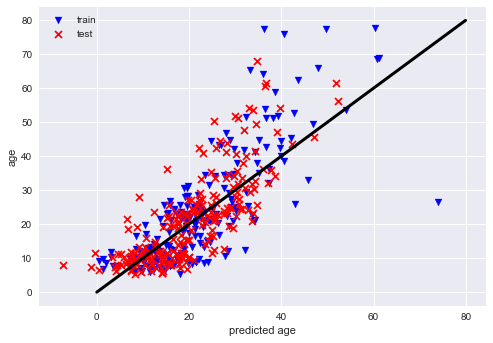

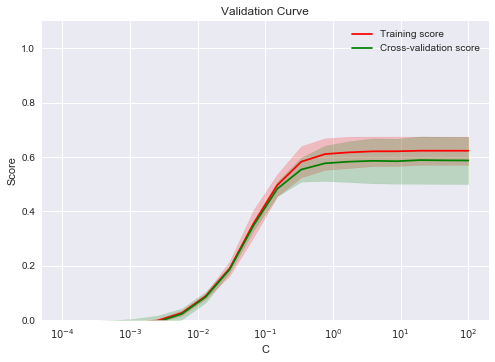

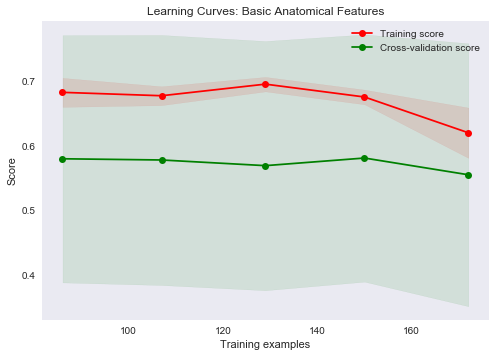

In [53]:
plot_pred(y_predicted_train_atf, y_train_ct, y_predicted_test_atf, y_test_ct)
plot_validation_curve(pipe_atf, X_train_atf, y_train_atf.as_matrix().ravel())
learning_curve_fct(X_train_atf, y_train_atf.as_matrix().ravel(), 'Basic Anatomical Features', pipe_atf)

In [54]:
%store X_train_atf
%store X_test_atf
%store y_train_atf
%store y_test_atf
%store df_atf

Stored 'X_train_atf' (DataFrame)
Stored 'X_test_atf' (DataFrame)
Stored 'y_train_atf' (DataFrame)
Stored 'y_test_atf' (DataFrame)
Stored 'df_atf' (DataFrame)


# Test HCP Data

## Setup

In [55]:
from pathlib import Path
import pandas as pd
import numpy as np
import subprocess
from datetime import date
import re

In [56]:
analysis_version = "2017_07_07"
project_dir_absolute = Path('/gpfs/gsfs6/users/NNDSP')

# Project Directory
project_dir = Path(project_dir_absolute) # needs to be pathlib.Path object

# Bids Directory
bids_fs = project_dir.joinpath('derived/fs5.3_subj') # freesurfer bids
bids_bar = project_dir.joinpath('derived/bar_subj') # baracus bids

# HCP Directory
hcp_dir = Path('/data/HCP/HCP_900/s3/hcp')

# Brain Age File
brain_age_file = project_dir.joinpath('anal/analysis_notebooks/NNDSP_famid.csv')

# HCP Outfir of Prepared Freesurfer Files
hcp_bar_dir = project_dir.joinpath('derived/bar_hcp_subj/')

# HCP Freesurfer Data
hcp_fs_dir = project_dir.joinpath('derived/fs_hcp_subj/')

print(hcp_fs_dir.absolute())

/gpfs/gsfs6/users/NNDSP/derived/fs_hcp_subj


## Load Subjects

In [57]:
# get all the necessary surf and stats file paths
get_files = False

if get_files:
    hcp_fs_subj = [p.as_posix() for p in hcp_dir.glob('??????')]
    hcp_fs_surf_subj = [p+'/T1w/'+p[len(p)-6:]+'/surf' for p in hcp_fs_subj]
    hcp_fs_stats_subj = [p+'/T1w/'+p[len(p)-6:]+'/stats' for p in hcp_fs_subj]

## Extract HCP Data

### Extract Subject Ages

In [58]:
import matplotlib.pyplot as plt
df_hcp_age = pd.read_csv(project_dir.joinpath('nino/HCP_ages.csv'))
df_hcp_age = pd.DataFrame(df_hcp_age[['Subject','Age_in_Yrs']])

### Extract HCP Data Simple Model

In [59]:
import os
from glob import glob

# get the subjects in the freesurfer directory
hcp_subj_dirs = [os.path.basename(s) for s in sorted(glob(os.path.join(hcp_bar_dir, "sub-*")))]

In [60]:
hcp_subjects_to_analyze = subject_to_anal(hcp_subj_dirs, hcp_bar_dir)

In [61]:
# get age and subject number
df_hcp_atf = pd.DataFrame([])
df_hcp_atf = df_hcp_atf.assign(Subject = [int(x[4:]) for x in hcp_subjects_to_analyze])
df_hcp_atf = df_hcp_atf.merge(df_hcp_age, on = 'Subject')

In [62]:
white_matter_hcp, grey_matter_hcp, csf_hcp, intra_cran_vol_hcp = get_anat_features(hcp_subjects_to_analyze, hcp_bar_dir)

In [63]:
# calculate white matter fraction
white_matter_hcp = calc_fraction(white_matter_hcp, intra_cran_vol_hcp)

# calculate grey matter fraction
grey_matter_hcp = calc_fraction(grey_matter_hcp, intra_cran_vol_hcp)

# calculate csf fraction
csf_hcp = calc_fraction(csf_hcp, intra_cran_vol_hcp)

In [64]:
df_hcp_atf = df_hcp_atf.assign(Intra_Cran_Vol = intra_cran_vol_hcp)
df_hcp_atf = df_hcp_atf.assign(WM_Frac = white_matter_hcp)
df_hcp_atf = df_hcp_atf.assign(GM_Frac = grey_matter_hcp)
df_hcp_atf = df_hcp_atf.assign(CSF_Frac = csf_hcp)

### Extract HCP Data Complex Model

In [65]:
hcp_features = extract_features(hcp_subjects_to_analyze, hcp_bar_dir)

## Test HCP Data

In [66]:
bar_subj_hcp = [p.as_posix() for p in hcp_bar_dir.glob('sub-*')] # search all subj in baracus directory
df_bar_subj_hcp = pd.DataFrame(bar_subj_hcp) # turn the subjects into df
df_bar_subj_hcp.columns = ['subj_path'] # rename column of subj paths to subj_path
df_bar_subj_hcp = df_bar_subj_hcp.assign(Subject = lambda df: df.subj_path.str.extract('sub-(\d{2,6})', expand=True))# add participant number column

In [67]:
df_single_subject_hcp = get_single_subject(df_bar_subj_hcp)

In [68]:
# merge aseg, ca, thickness and stacked model with real ages
df_single_subject_hcp = df_single_subject_hcp.rename(columns={'participant': 'Subject'})
df_single_subject_hcp = df_single_subject_hcp.sort_values(by='Subject')
df_single_subject_hcp = df_single_subject_hcp.merge(df_hcp_age, on = 'Subject')

In [69]:
# error of baracus model
from sklearn.metrics import mean_absolute_error

print("Mean Absolute Error (Aseg):", mean_absolute_error(df_single_subject_hcp.iloc[:, 1], df_single_subject_hcp.iloc[:, 5]))
print("Mean Absolute Error (Area):", mean_absolute_error(df_single_subject_hcp.iloc[:, 2], df_single_subject_hcp.iloc[:, 5]))
print("Mean Absolute Error (Thickness):", mean_absolute_error(df_single_subject_hcp.iloc[:, 3], df_single_subject_hcp.iloc[:, 5]))
print("Mean Absolute Error (Stacked Model):", mean_absolute_error(df_single_subject_hcp.iloc[:, 4], df_single_subject_hcp.iloc[:, 5]))

Mean Absolute Error (Aseg): 8.60684507508
Mean Absolute Error (Area): 108.869897623
Mean Absolute Error (Thickness): 13.3445398192
Mean Absolute Error (Stacked Model): 7.92587784783


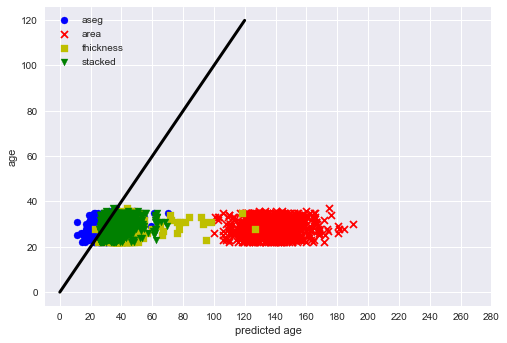

In [70]:
bar_plot(df_single_subject_hcp, start_at = 1, end_at=5)

### Test Against Complex Model

In [71]:
df_data_hcp_ct = get_source_data('thickness', hcp_features, df_hcp_age, on='Subject')

In [72]:
y_predicted_hcp_ct = pipe_ct.predict(df_data_hcp_ct.iloc[:,:5124])

In [73]:
df_data_hcp_sv = get_source_data('aseg', hcp_features, df_hcp_age, on='Subject')

In [74]:
y_predicted_hcp_sv = pipe_sv.predict(df_data_hcp_sv.iloc[:,:66])

In [75]:
%store df_data_hcp_sv

Stored 'df_data_hcp_sv' (DataFrame)


In [76]:
df_data_hcp_ca = get_source_data('area', hcp_features, df_hcp_age, on='Subject')

In [77]:
y_predicted_hcp_ca = pipe_ca.predict(df_data_hcp_ca.iloc[:,:5124])

In [78]:
#### Stacked Anatomy
df_stack_hcp = pd.DataFrame([])
df_stack_hcp['aseg'] = y_predicted_hcp_sv
df_stack_hcp['ct'] = y_predicted_hcp_ct
df_stack_hcp['ca'] = y_predicted_hcp_ca
df_stack_hcp['Subject'] = df_data_hcp_ct.Subject.values

In [79]:
y_predicted_stack_hcp = pipe_stack.predict(df_stack_hcp.iloc[:,:3])

In [80]:
# test mean absolute error
from sklearn.metrics import mean_absolute_error, r2_score

print("Mean Absolute Error (HCP):", mean_absolute_error(df_data_hcp_ca.iloc[:,5125], y_predicted_stack_hcp))

Mean Absolute Error (HCP): 5.32367901663


### Test Against Simple Model

In [81]:
# test HCP Inputs with Simple Model
y_predicted_hcp_atf = pipe_atf.predict(df_hcp_atf.iloc[:, 2:])

In [82]:
# y_predicted_hcp_atf vs. age assigned

# test mean absolute error
from sklearn.metrics import mean_absolute_error, r2_score

print("Mean Absolute Error (HCP):", mean_absolute_error(df_hcp_atf.Age_in_Yrs, y_predicted_hcp_atf))

Mean Absolute Error (HCP): 10.7053027528


In [83]:
%store df_hcp_atf

Stored 'df_hcp_atf' (DataFrame)


# Test NKI Data

## Setup

In [84]:
analysis_version = "2017_07_07"
project_dir_absolute = Path('/gpfs/gsfs6/users/NNDSP')

# Project Directory
project_dir = Path(project_dir_absolute) # needs to be pathlib.Path object

# Bids Directory
bids_fs = project_dir.joinpath('derived/fs5.3_subj') # freesurfer bids
bids_bar = project_dir.joinpath('derived/bar_subj') # baracus bids

# HCP Directory
hcp_dir = Path('/data/NNDSP/anal/NKI')

# Brain Age File
brain_age_file = project_dir.joinpath('anal/analysis_notebooks/NNDSP_famid.csv')

# HCP Behavioral Data File
nki_bh_file = project_dir.joinpath('anal/analysis_notebooks/participants.tsv')

# HCP Outfir of Prepared Freesurfer Files
nki_bar_dir = project_dir.joinpath('derived/bar_nki_subj/')

# NKI Freesurfer Data
nki_fs_dir = project_dir.joinpath('derived/fs_nki_subj/')

print(hcp_fs_dir.absolute())

/gpfs/gsfs6/users/NNDSP/derived/fs_hcp_subj


In [85]:
df_nki_ages = pd.read_csv(project_dir.joinpath('anal/analysis_notebooks/participants.tsv'), sep='\t')

## Extract NKI Data

In [86]:
import os
from glob import glob

# get the subjects in the freesurfer directory
nki_subj_dirs = [os.path.basename(s) for s in sorted(glob(os.path.join(nki_bar_dir, "sub-*")))]

In [87]:
nki_subjects_to_analyze = subject_to_anal(nki_subj_dirs, nki_bar_dir)

In [88]:
# get age and subject number
df_nki_atf = pd.DataFrame([])
df_nki_atf = df_nki_atf.assign(participant_name = [x for x in nki_subjects_to_analyze])
df_nki_atf = df_nki_atf.assign(participant_id = [x[4:13] for x in df_nki_atf.participant_name.values])
df_nki_atf = df_nki_atf.drop_duplicates(subset='participant_id', keep='first')
df_nki_atf = df_nki_atf.merge(df_nki_ages, on = 'participant_id')

In [89]:
white_matter_nki, grey_matter_nki, csf_nki, intra_cran_vol_nki = get_anat_features(df_nki_atf.participant_name.values, nki_bar_dir)

In [90]:
# calculate white matter fraction
white_matter_nki = calc_fraction(white_matter_nki, intra_cran_vol_nki)

# calculate grey matter fraction
grey_matter_nki = calc_fraction(grey_matter_nki, intra_cran_vol_nki)

# calculate csf fraction
csf_nki = calc_fraction(csf_nki, intra_cran_vol_nki)

In [93]:
df_nki_atf = df_nki_atf.assign(Intra_Cran_Vol = intra_cran_vol_nki)
df_nki_atf = df_nki_atf.assign(WM_Frac = white_matter_nki)
df_nki_atf = df_nki_atf.assign(GM_Frac = grey_matter_nki)
df_nki_atf = df_nki_atf.assign(CSF_Frac = csf_nki)

### Extract NKI Data Complex Model

In [94]:
nki_features = extract_features(df_nki_atf.participant_name.values, nki_bar_dir)

### Test against LeiCa_LIFE Model

In [95]:
df_bar_subj_nki = pd.DataFrame([p.as_posix() for p in nki_bar_dir.glob('sub-*')]) # search all subj in baracus directory and turn the subjects into df
df_bar_subj_nki.columns = ['subj_path'] # rename column of subj paths to subj_path
df_bar_subj_nki = df_bar_subj_nki.assign(participant_id = lambda df: df.subj_path.str.extract('sub-(A\d{2,8})', expand=True))# add participant number column

In [96]:
df_bar_subj_nki = df_bar_subj_nki.sort_values(by='participant_id')
df_bar_subj_nki = df_bar_subj_nki.drop_duplicates(subset='participant_id', keep='first')

In [97]:
df_bar_subj_nki = df_bar_subj_nki.merge(df_nki_ages, on='participant_id')

In [98]:
df_single_subject_nki = get_single_subject(df_bar_subj_nki, to_int=False)

In [99]:
# merge aseg, ca, thickness and stacked model with real ages
df_single_subject_nki = df_single_subject_nki.rename(columns={'participant': 'participant_id'})
df_single_subject_nki = df_single_subject_nki.sort_values(by='participant_id')
df_single_subject_nki = df_single_subject_nki.merge(df_nki_ages, on = 'participant_id')

In [100]:
# error of baracus model
from sklearn.metrics import mean_absolute_error

print("Mean Absolute Error (Aseg):", mean_absolute_error(df_single_subject_nki.iloc[:, 1], df_single_subject_nki.age))
print("Mean Absolute Error (Area):", mean_absolute_error(df_single_subject_nki.iloc[:, 2], df_single_subject_nki.age))
print("Mean Absolute Error (Thickness):", mean_absolute_error(df_single_subject_nki.iloc[:, 3], df_single_subject_nki.age))
print("Mean Absolute Error (Stacked Model):", mean_absolute_error(df_single_subject_nki.iloc[:, 4], df_single_subject_nki.age))

Mean Absolute Error (Aseg): 10.0268668575
Mean Absolute Error (Area): 100.530877128
Mean Absolute Error (Thickness): 9.83434243637
Mean Absolute Error (Stacked Model): 9.45275023262


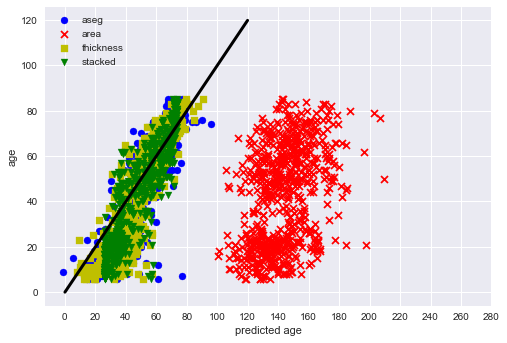

In [101]:
bar_plot(df_single_subject_nki, start_at=1, end_at=5)

### Test Against Complex Model

In [102]:
df_data_nki_ct = get_source_data('thickness', nki_features, df_nki_ages, on='participant_id', is_string=True)

In [103]:
y_predicted_nki_ct = pipe_ct.predict(df_data_nki_ct.iloc[:,:5124])

In [104]:
df_data_nki_sv = get_source_data('aseg', nki_features, df_nki_ages, on='participant_id', is_string=True)

In [105]:
y_predicted_nki_sv = pipe_sv.predict(df_data_nki_sv.iloc[:,:66])

In [106]:
df_data_nki_ca = get_source_data('area', nki_features, df_nki_ages, on='participant_id', is_string=True)

In [107]:
y_predicted_nki_ca = pipe_ca.predict(df_data_nki_ca.iloc[:,:5124])

In [108]:
#### Stacked Anatomy
df_stack_nki = pd.DataFrame([])
df_stack_nki['aseg'] = y_predicted_nki_sv
df_stack_nki['ct'] = y_predicted_nki_ct
df_stack_nki['ca'] = y_predicted_nki_ca
df_stack_nki['participant_id'] = df_data_nki_ct.participant_id.values

In [109]:
y_predicted_stack_nki = pipe_stack.predict(df_stack_nki.iloc[:,:3])

In [110]:
# test mean absolute error
from sklearn.metrics import mean_absolute_error, r2_score

print("Mean Absolute Error (NKI):", mean_absolute_error(df_data_nki_ca.age, y_predicted_stack_nki))

Mean Absolute Error (NKI): 8.2081848525


In [111]:
%store df_data_nki_sv

Stored 'df_data_nki_sv' (DataFrame)


In [112]:
%store df_nki_atf
%store nki_features
%store df_nki_ages

Stored 'df_nki_atf' (DataFrame)
Stored 'nki_features' (list)
Stored 'df_nki_ages' (DataFrame)


### Test Against Simple Model

In [113]:
if 'participant_name' in df_nki_atf.columns:
    del df_nki_atf['participant_name']

In [114]:
# test HCP Inputs with Simple Model
y_predicted_nki_atf = pipe_atf.predict(df_nki_atf.iloc[:, 4:])

In [115]:
# y_predicted_hcp_atf vs. age assigned

# test mean absolute error
from sklearn.metrics import mean_absolute_error, r2_score

print("Mean Absolute Error (NKI):", mean_absolute_error(df_nki_atf.age, y_predicted_nki_atf))

Mean Absolute Error (NKI): 11.7410101077


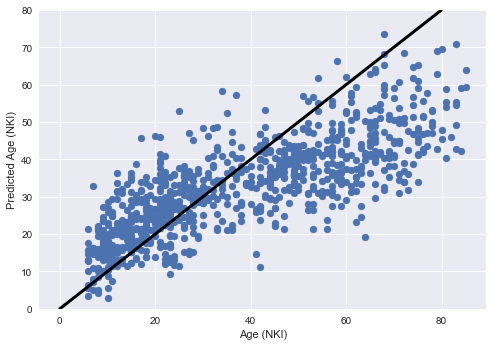

In [116]:
import matplotlib.pyplot as plt

plt.scatter(df_nki_atf.age, y_predicted_nki_atf)
plt.plot(numpy.arange(0,80,0.1), numpy.arange(0,80,0.1), c='black', linewidth = 3)
plt.xlabel("Age (NKI)")
plt.ylabel("Predicted Age (NKI)")
plt.ylim(0, 80)
plt.show()

In [117]:
%store df_nki_atf

Stored 'df_nki_atf' (DataFrame)


# Statistical Tests

In [118]:
%run /data/NNDSP/anal/analysis_notebooks/stat_tests.ipynb

## Hypothesis #1

If we train a previously presented machine learning model predicting age from a large number of derived anatomical features on a new data set, it will perform better than chance at predicting age outside of the training data.

### Chance on Shaw Data

In [119]:
# get all the subject ages from Shaw Data
subject_ages = [x for x in df_data_ca.age_at_scan]
df_subject_ages = pd.DataFrame(subject_ages)
# df of random age predictions
df_random_ages = pd.DataFrame([])
df_random_ages = df_random_ages.assign(MASKID = df_data_ca.MASKID)

In [120]:
df_random_ages = random_its(1000, df_random_ages, subject_ages)

In [121]:
arr_mae = get_arr_mae(df_random_ages, df_subject_ages)

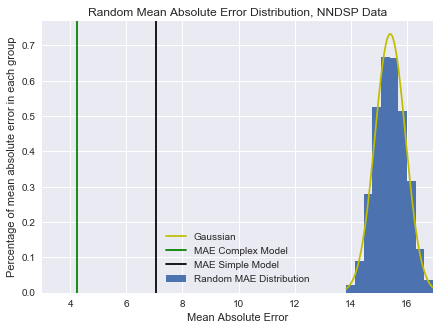

In [122]:
lines = {
    'MAE Complex Model' : scores_test.get_value(index='pred_age_test', col='mae'),
    'MAE Simple Model' : mean_absolute_error(y_train_atf, y_predicted_train_atf),
    #'MAE Simple Stacked Model' : mean_absolute_error(y_test_atf, y_predicted_test_ss),
}
plot_rand_hist(arr_mae, lines, title='Random Mean Absolute Error Distribution, NNDSP Data', set_context='notebook',
               fig_tuple=(7, 5))

In [123]:
print("Percentile of MAE Complex Model", percentile(arr_mae, scores_test.get_value(index='pred_age_test', col='mae')))

Percentile of MAE Complex Model 0.0


In [124]:
print("Percentile of MAE Simple Model", percentile(arr_mae, mean_absolute_error(y_train_atf, y_predicted_train_atf)))

Percentile of MAE Simple Model 0.0


In [125]:
print("Percentile of MAE Baracus", percentile(arr_mae, mean_absolute_error(df_bar_subj.iloc[:, 5], df_bar_subj.iloc[:, 7])))

Percentile of MAE Baracus 0.0


### Chance on HCP Data

In [126]:
# get all the subject ages
subject_hcp_ages = [x for x in df_hcp_age.Age_in_Yrs]
df_hcp_subject_ages = pd.DataFrame(subject_hcp_ages)
# df of random age predictions
df_hcp_random_ages = pd.DataFrame([])
df_hcp_random_ages = df_hcp_random_ages.assign(Subject = df_hcp_age.Subject)

In [127]:
df_hcp_random_ages = random_its(1000, df_hcp_random_ages, subject_hcp_ages)

In [128]:
arr_mae_hcp = get_arr_mae(df_hcp_random_ages, df_hcp_subject_ages)

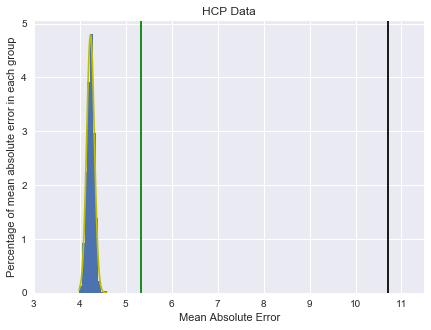

In [129]:
hcp_lines = {
    'MAE Complex Model (HCP)' : mean_absolute_error(df_data_hcp_ca.iloc[:,5125], y_predicted_stack_hcp),
    'MAE Simple Model (HCP)' : mean_absolute_error(df_hcp_atf.Age_in_Yrs, y_predicted_hcp_atf)
}
plot_rand_hist(arr_mae_hcp, hcp_lines, x_max = 11.5, title='HCP Data',
              set_context='notebook', fig_tuple=(7, 5), legend=False)

In [130]:
print("Percentile of MAE Complex Model (HCP)", percentile(arr_mae_hcp, 
                                                    mean_absolute_error(df_data_hcp_ca.iloc[:,5125], y_predicted_stack_hcp)))

Percentile of MAE Complex Model (HCP) 100.0


In [131]:
print("Percentile of MAE Simple Model (HCP)", percentile(arr_mae_hcp, 
                                                  mean_absolute_error(df_hcp_atf.Age_in_Yrs, y_predicted_hcp_atf)))

Percentile of MAE Simple Model (HCP) 100.0


In [132]:
print("Percentile of MAE Baracus (HCP)", percentile(arr_mae_hcp,
                                                    mean_absolute_error(df_single_subject_hcp.iloc[:, 4], df_single_subject_hcp.iloc[:, 5])))

Percentile of MAE Baracus (HCP) 100.0


### Chance on NKI Data

In [133]:
# get all the subject ages
subject_nki_ages = [x for x in df_nki_atf.age]
df_nki_subject_ages = pd.DataFrame(subject_nki_ages)
# df of random age predictions
df_nki_random_ages = pd.DataFrame([])
df_nki_random_ages = df_nki_random_ages.assign(participant_id = df_nki_atf.participant_id)

In [134]:
df_nki_random_ages = random_its(1000, df_nki_random_ages, subject_nki_ages)

In [135]:
arr_mae_nki = get_arr_mae(df_nki_random_ages, df_nki_subject_ages)

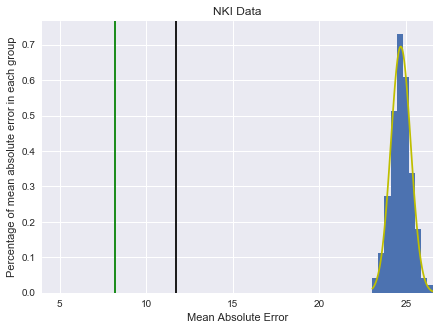

In [136]:
nki_lines = {
    'MAE Complex Model (NKI)' : mean_absolute_error(df_data_nki_ca.iloc[:,5125], y_predicted_stack_nki),
    'MAE Simple Model (NKI)' : mean_absolute_error(df_nki_atf.age, y_predicted_nki_atf),
    #'MAE Simple Stacked Model (NKI)' : mean_absolute_error(df_nki_atf.age, y_predicted_nki_ss),
}
plot_rand_hist(arr_mae_nki, nki_lines, xlim_min =4, title='NKI Data',
              set_context='notebook', fig_tuple=(7, 5), legend=False)

In [137]:
print("Percentile of MAE Complex Model (NKI)", percentile(arr_mae_nki, 
                                                    mean_absolute_error(df_data_nki_ca.iloc[:,5125], 
                                                                        y_predicted_stack_nki)))

Percentile of MAE Complex Model (NKI) 0.0


In [138]:
print("Percentile of MAE Simple Model (NKI)", percentile(arr_mae_nki, 
                                                  mean_absolute_error(df_nki_atf.age, y_predicted_nki_atf)))

Percentile of MAE Simple Model (NKI) 0.0


In [139]:
print("Percentile of MAE Baracus (HCP)", percentile(arr_mae_nki,
                                                    mean_absolute_error(df_single_subject_nki.age, df_single_subject_nki.iloc[:, 5])))

Percentile of MAE Baracus (HCP) 0.0


## Hypothesis #2 

The model trained with many derived features will have better out of sample performance than a model trained with fewer, simpler features.

### Complex Model vs. Simple Model

In [140]:
temp_tr = y_train_atf.assign(y_pred = y_predicted_train_atf).sort_index()

statistic, pvalue, sum = wilcoxon_sum(np.subtract(temp_tr.y_pred.values, temp_tr.age_at_scan.values), 
                                      np.subtract(dd_train.pred_age_train, dd_train.age_at_scan))
print("Statistic: ", statistic, '\n', "Pvalue: ", pvalue, '\n',"Correlation: ", statistic/sum)

Statistic:  10370.0 
 Pvalue:  0.17452044581 
 Correlation:  0.446597760551


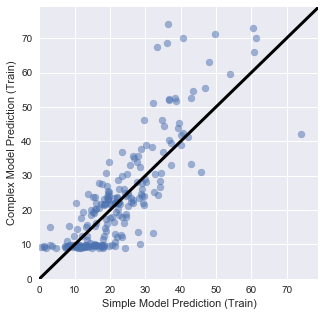

In [141]:
plot_simple_v_complex(temp_tr.y_pred.values, dd_train.pred_age_train, "(Train)")

In [142]:
temp_ts = y_test_atf.assign(y_pred = y_predicted_test_atf).sort_index()
statistic, pvalue, sum = wilcoxon_sum(np.subtract(temp_ts.y_pred.values, temp_ts.age_at_scan.values), 
                                      np.subtract(dd_test.pred_age_test, dd_test.age_at_scan))
print("Statistic: ", statistic, '\n', "Pvalue: ", pvalue, '\n',"Correlation: ", statistic/sum)

Statistic:  11672.0 
 Pvalue:  0.960104699849 
 Correlation:  0.498037207715


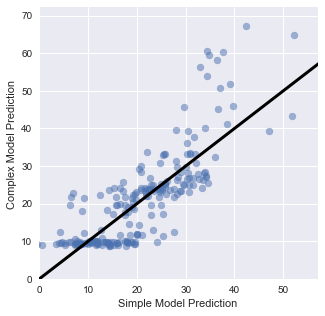

In [143]:
plot_simple_v_complex(temp_ts.y_pred, dd_test.pred_age_test, "", fig_tuple=(5, 5), fig_title='simple_graph.png')

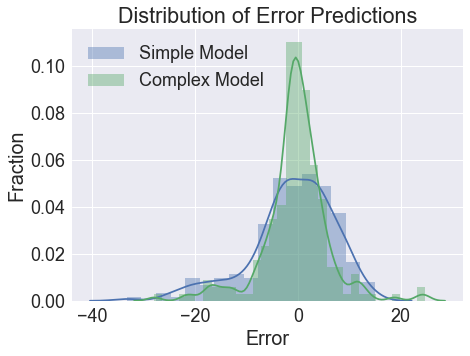

In [144]:
plot_list = {
    "Simple Model" : np.subtract(temp_ts.y_pred.values, temp_ts.age_at_scan.values), 
    "Complex Model" : np.subtract(dd_test.pred_age_test, dd_test.age_at_scan),
}
plot_ae_hist(plot_list, title='Distribution of Error Predictions', set_context='notebook',
            fig_tuple=(7, 5), file_title='simple_hist.png')

In [145]:
%store dd_test

Stored 'dd_test' (DataFrame)


## Hypothesis #3

The model trained with many derived features will perform better than the model with fewer, simpler features when tested on data collected at different sites. 

### HCP Data

#### Complex Model vs Simple Model

In [146]:
%store -r y_predicted_hcp_ss

In [147]:
df_hcp_pred_data = get_wil_helper(df_hcp_atf, y_predicted_hcp_atf, y_predicted_hcp_ss, 
                                  y_predicted_stack_hcp, df_hcp_age, subj='Subject')

In [148]:
statistic, pvalue, sum = wilcoxon_sum(df_hcp_pred_data.Atf_Err, df_hcp_pred_data.Complx_Err)
print("Statistic: ", statistic, '\n', "Pvalue: ", pvalue, '\n',"Correlation: ", statistic/sum)

Statistic:  26490.0 
 Pvalue:  5.03785472171e-112 
 Correlation:  0.0660664405427


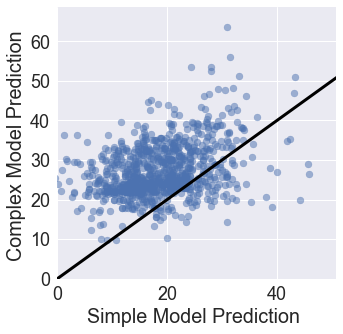

In [149]:
plot_simple_v_complex(df_hcp_pred_data.atf_pred, df_hcp_pred_data['stack'], title='', 
                      label='Simple', fig_tuple=(5, 5))

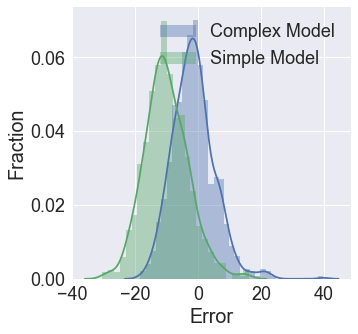

In [150]:
plot_list_hcp = {
    "Complex Model" : df_hcp_pred_data.Complx_Err,
    "Simple Model" : df_hcp_pred_data.Atf_Err
}
plot_ae_hist(plot_list_hcp)

In [151]:
%store df_hcp_pred_data

Stored 'df_hcp_pred_data' (DataFrame)


#### Complex Model vs Simple Stacked Model

In [152]:
statistic, pvalue, sum = wilcoxon_sum(df_hcp_pred_data.SS_Err, df_hcp_pred_data.Complx_Err)
print("Statistic: ", statistic, '\n', "Pvalue: ", pvalue, '\n',"Correlation: ", statistic/sum)

Statistic:  43687.0 
 Pvalue:  2.44590728542e-91 
 Correlation:  0.108956005587


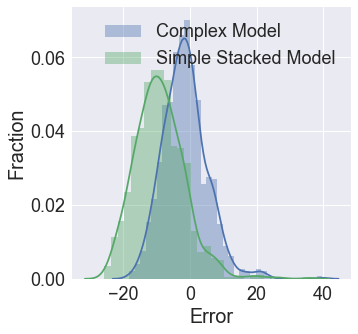

In [153]:
plot_list_hcp_s = {
    "Complex Model" : df_hcp_pred_data.Complx_Err,
    "Simple Stacked Model" : df_hcp_pred_data.SS_Err
}
plot_ae_hist(plot_list_hcp_s)

### NKI Data

#### Complex Model vs Simple Model

In [154]:
%store -r y_predicted_nki_ss

In [155]:
df_nki_pred_data = get_wil_helper(df_nki_atf, y_predicted_nki_atf, y_predicted_nki_ss, y_predicted_stack_nki,
                                 df_nki_ages, subj='participant_id')

In [156]:
statistic, pvalue, sum = wilcoxon_sum(df_nki_pred_data.Atf_Err, df_nki_pred_data.Complx_Err)
print("Statistic: ", statistic, '\n', "Pvalue: ", pvalue, '\n',"Correlation: ", statistic/sum)

Statistic:  147517.0 
 Pvalue:  7.07046761919e-11 
 Correlation:  0.373729466249


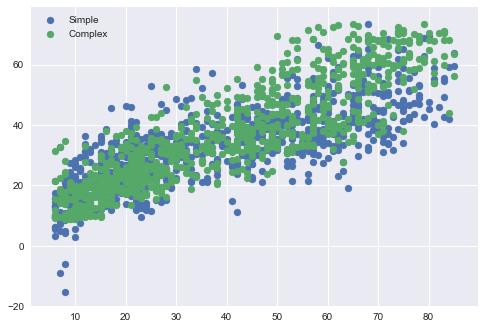

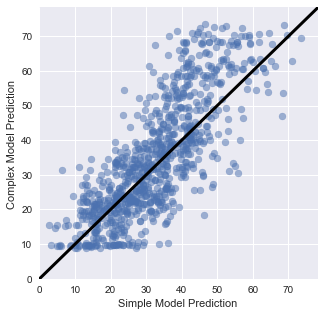

In [157]:
import seaborn as sns
sns.set_context('notebook')
plt.scatter(df_nki_pred_data.age, df_nki_pred_data.atf_pred, label = 'Simple')
plt.scatter(df_nki_pred_data.age, df_nki_pred_data['stack'], label ='Complex')
plt.legend(loc='best')
plt.show()
plot_simple_v_complex(df_nki_pred_data.atf_pred, df_nki_pred_data['stack'], title='',
                     fig_tuple=(5, 5), fig_title='nki_graph.png')

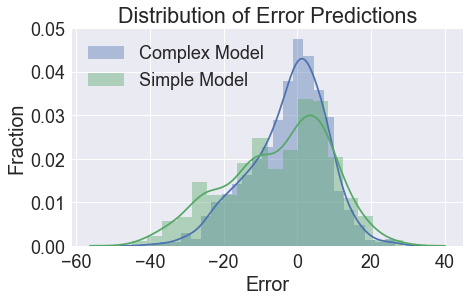

In [158]:
plot_list_nki = {
    "Complex Model" : df_nki_pred_data.Complx_Err,
    "Simple Model" : df_nki_pred_data.Atf_Err
}
plot_ae_hist(plot_list_nki, title='Distribution of Error Predictions', set_context='notebook',
            fig_tuple=(7, 4), file_title='nki_hist.png')

In [159]:
%store df_nki_pred_data

Stored 'df_nki_pred_data' (DataFrame)


#### Complex Model vs Simple Stacked Model

In [160]:
statistic, pvalue, sum = wilcoxon_sum(df_nki_pred_data.SS_Err, df_nki_pred_data.Complx_Err)
print("Statistic: ", statistic, '\n', "Pvalue: ", pvalue, '\n',"Correlation: ", statistic/sum)

Statistic:  118424.0 
 Pvalue:  5.46075954813e-25 
 Correlation:  0.300023307897


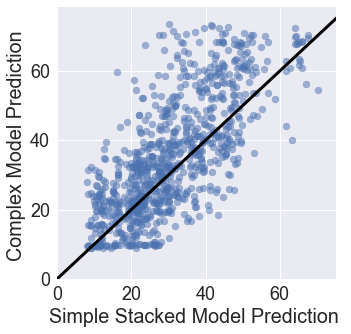

In [161]:
plot_simple_v_complex(df_nki_pred_data.ss_pred, df_nki_pred_data['stack'], title='', 
                      label='Simple Stacked', fig_tuple=(5, 5))

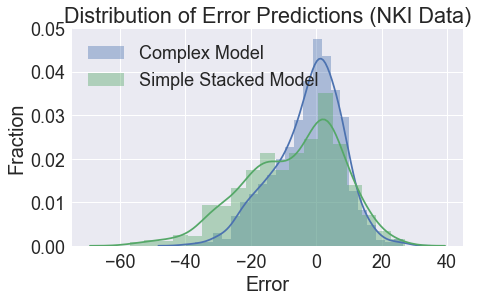

In [162]:
plot_list_nki_s = {
    "Complex Model" : df_nki_pred_data.Complx_Err,
    "Simple Stacked Model" : df_nki_pred_data.SS_Err
}
plot_ae_hist(plot_list_nki_s, title='Distribution of Error Predictions (NKI Data)', set_context='notebook',
            fig_tuple=(7, 4))

# Exploratory Analysis

## Train Test Split

In [164]:
df_tt_split = mult_iterations(400, df_data_ct, df_data_sv, df_data_ca, df_data_hcp_ct, df_data_hcp_sv, df_data_hcp_ca, df_data_nki_ct, df_data_nki_sv, df_data_nki_ca,
                   df_atf, df_hcp_atf, df_nki_atf)

Fitting stacking model
best max_depth: 3
0
Fitting stacking model
best max_depth: 5
1
Fitting stacking model
best max_depth: 9
2
Fitting stacking model
best max_depth: 5
3
Fitting stacking model
best max_depth: 5
4
Fitting stacking model
best max_depth: 4
5
Fitting stacking model
best max_depth: 3
6
Fitting stacking model
best max_depth: 4
7
Fitting stacking model
best max_depth: 5
8
Fitting stacking model
best max_depth: 4
9
Fitting stacking model
best max_depth: 5
10
Fitting stacking model
best max_depth: 5
11
Fitting stacking model
best max_depth: 12
12
Fitting stacking model
best max_depth: 3
13
Fitting stacking model
best max_depth: 4
14
Fitting stacking model
best max_depth: 6
15
Fitting stacking model
best max_depth: 4
16
Fitting stacking model
best max_depth: 4
17
Fitting stacking model
best max_depth: 3
18
Fitting stacking model
best max_depth: 4
19
Fitting stacking model
best max_depth: 4
20
Fitting stacking model
best max_depth: 4
21
Fitting stacking model
best max_depth: 3


best max_depth: 5
184
Fitting stacking model
best max_depth: 4
185
Fitting stacking model
best max_depth: 4
186
Fitting stacking model
best max_depth: 3
187
Fitting stacking model
best max_depth: 3
188
Fitting stacking model
best max_depth: 4
189
Fitting stacking model
best max_depth: 5
190
Fitting stacking model
best max_depth: 5
191
Fitting stacking model
best max_depth: 4
192
Fitting stacking model
best max_depth: 4
193
Fitting stacking model
best max_depth: 3
194
Fitting stacking model
best max_depth: 4
195
Fitting stacking model
best max_depth: 5
196
Fitting stacking model
best max_depth: 9
197
Fitting stacking model
best max_depth: 4
198
Fitting stacking model
best max_depth: 4
199
Fitting stacking model
best max_depth: 4
200
Fitting stacking model
best max_depth: 15
201
Fitting stacking model
best max_depth: 17
202
Fitting stacking model
best max_depth: 3
203
Fitting stacking model
best max_depth: 8
204
Fitting stacking model
best max_depth: 3
205
Fitting stacking model
best max

best max_depth: 4
366
Fitting stacking model
best max_depth: 4
367
Fitting stacking model
best max_depth: 8
368
Fitting stacking model
best max_depth: 6
369
Fitting stacking model
best max_depth: 4
370
Fitting stacking model
best max_depth: 6
371
Fitting stacking model
best max_depth: 4
372
Fitting stacking model
best max_depth: 4
373
Fitting stacking model
best max_depth: 5
374
Fitting stacking model
best max_depth: 3
375
Fitting stacking model
best max_depth: 3
376
Fitting stacking model
best max_depth: 5
377
Fitting stacking model
best max_depth: 4
378
Fitting stacking model
best max_depth: 4
379
Fitting stacking model
best max_depth: 4
380
Fitting stacking model
best max_depth: 4
381
Fitting stacking model
best max_depth: 6
382
Fitting stacking model
best max_depth: 4
383
Fitting stacking model
best max_depth: 4
384
Fitting stacking model
best max_depth: 6
385
Fitting stacking model
best max_depth: 4
386
Fitting stacking model
best max_depth: 5
387
Fitting stacking model
best max_d

In [168]:
df_tt_split.head()

,stack_ts,stack_hcp,stack_nki,simple_ts,simple_hcp,simple_nki,pval_ts,pval_hcp,pval_nki
0,4.31326,5.21719,8.88666,6.58418,10.7322,12.6449,0.0166906,7.91839e-109,1.59253e-19
1,3.88606,5.53871,8.33963,6.87314,10.1738,12.6105,0.0398539,9.5753e-119,6.94748e-23
2,4.32291,5.60234,9.54572,7.45288,10.8739,13.5433,0.00195472,8.42092e-123,7.62108e-19
3,4.2179,5.24233,8.72992,6.64627,9.51845,12.9229,0.1964,1.39309e-118,1.62177e-10
4,3.97966,5.54372,7.90955,6.77133,9.45943,12.8832,0.745072,6.21325e-112,4.47204e-28


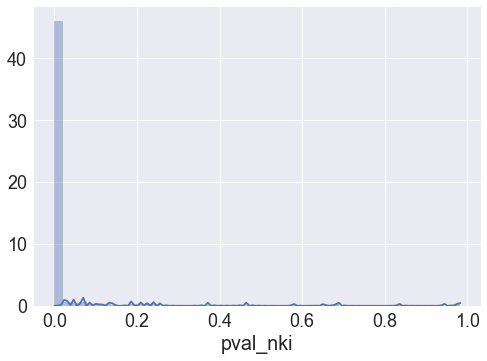

In [170]:
sns.distplot(df_tt_split.pval_nki)
plt.show()

In [171]:
df_tt_split[df_tt_split.pval_nki > 0.05]

,stack_ts,stack_hcp,stack_nki,simple_ts,simple_hcp,simple_nki,pval_ts,pval_hcp,pval_nki
16,3.93101,5.1435,9.70749,7.15596,10.2333,13.2556,0.273018,3.31495e-105,0.133987
35,4.06496,6.1462,9.72286,6.99122,10.0585,13.2341,0.328268,5.5558e-84,0.578103
42,4.39868,5.72528,10.5425,6.86339,10.0578,13.388,0.241967,9.38228e-113,0.142756
54,4.54008,4.61225,10.3346,7.35659,9.92577,13.4642,0.480345,3.05034e-113,0.0603437
63,4.42572,5.51114,9.78581,6.69331,9.12227,12.5741,0.473607,2.13086e-95,0.102601
65,4.18749,5.29542,9.13725,6.81619,9.55958,12.679,0.292506,1.31205e-108,0.207297
74,3.88369,5.00773,9.75425,6.55451,9.46498,12.2801,0.134288,9.23722e-100,0.213537
77,3.85604,4.53329,9.76353,6.64283,9.94281,12.1334,0.287548,9.50228e-110,0.188844
85,3.8173,4.57736,10.5896,6.69891,10.1376,13.1492,0.247703,1.13905e-122,0.94213
96,4.09594,4.98155,10.6526,7.45408,10.1197,13.4457,0.453054,6.62465e-120,0.067464


In [ ]:
plt.scatter(df_tt_split.stack_ts, df_tt_split.stack_nki)
plt.scatter(df_tt_split.simple_ts, df_tt_split.simple_nki)
plt.show()